# Human proteins Network



In [1]:
import csv
import scipy 
from scipy import sparse
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from networkx.algorithms.community.quality import performance, coverage
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import community
from collections import defaultdict

The following lines of code are used to import the adjacency matrix of the human proteins network. 
Then, a scipy sparse matrix is created to store such matrix.

### Import Adjacency matrix

In [2]:
class Network():
    
    def __init__(self,filename):
        self.filename = filename
        self.import_Network()
        
    def import_Network(self):

        list_rows=[]

        with open(self.filename) as tsvfile:
            reader = csv.DictReader(tsvfile, dialect='excel-tab')
            for row in reader:
                s = row['% asym unweighted'].split()
                list_rows.append(list(map(int, s)) )
    
        vals = np.array(list_rows)

        self.row = vals[:,0]
        self.col = vals[:,1]
        self.data = np.ones(vals.shape[0])
        self.num_vertices = int(np.max(self.col)) + 1
        self.num_edges = int(np.sum(self.data))
        
        
        self.adjacency = scipy.sparse.csr_matrix( (self.data, (self.row,self.col)), 
                                                 shape = (self.num_vertices,self.num_vertices))
        self.set_laplacian_matrix()
        
        
    def set_laplacian_matrix(self):
        out_degree = self.get_outdegree()
        
        self.laplacian = scipy.sparse.lil_matrix((self.num_vertices,self.num_vertices))
        self.laplacian.setdiag(np.array(out_degree).flatten())
        self.laplacian = self.laplacian - scipy.sparse.lil_matrix(self.adjacency)
        self.laplacian = scipy.sparse.csr_matrix(self.laplacian)        
        
        
    def get_indegree(self):
        degs = self.adjacency.sum(axis = 0)
        return degs.flatten()
    
    def get_outdegree(self):
        degs = self.adjacency.sum(axis = 1)
        return degs.flatten()
    

net = Network('out.maayan-figeys')


## Communities

We can also define the graph using the NetworkX package.

In [3]:
G = nx.from_scipy_sparse_matrix(net.adjacency, create_using = nx.DiGraph())

In this notebook we are going to study our network communities. 

The quality of a network partition can be measured by the partition **modularity**. Modularity is the fraction of the edges that fall within the given groups minus the expected fraction if edges were distributed at random. 

$$
Q = \sum_i (e_{ii} - a_i^2)
$$

where $e_{ij}$ is the fraction of the total number of links starting at a node in partition $i$ and ending at a node in partition $j$, and $a_i^2$ is the number of intracommunity links. The modularity falls into the range $[-1/2, 1]$. Higher values of modularity represent better partitions.

## 1. Louvain algorithm

An **optimal partition** is the one with highest modularity. In order to find this optimal partition, we will use **Louvain algorithm**. This algorithm roughly works as follows:

+ *First phase*: First, each node is assigned to its own community. Then, for each node $i$, the change in modularity ($\nabla Q$) is calculated for removing $i$ from its own community and adding it to a community of $j$, a neighbour of $i$. When $\nabla Q$ is calculated for all neighbours of $i$, $i$ is assigned to the neighbour $j$ with highest modularity increase. If no increase is possible, $i$ remains in its community. The process is repeated to all nodes until no modularity increase is achieved. 

+ *Second phase:* it groups all of the nodes in the same community and builds a new network where nodes are the communities from the previous phase. Any links between nodes of the same community are now represented by self-loops on the new community node and links from multiple nodes in the same community to a node in a different community are represented by weighted edges between communities. Once the new network is created, the second phase has ended and the first phase can be re-applied to the new network.

In [18]:
#Compute the best partition
#We have to transform the graph to undirected in order to compute the partition
H = G.to_undirected()
partition = community.best_partition(H)

#Compute the induced graph (the graph with nodes corresponding to partitions)
ind = community.induced_graph(partition, H)
num_part = ind.number_of_nodes()

print('Number of partitions: ', num_part)

Number of partitions:  25


The Louvain algorithm gave us 23 communities for the network. Let's visualize the nodes coloured according to the community.

### Partition visualization

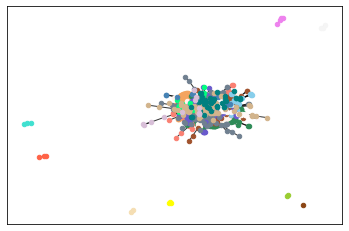

In [19]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(H)
count = 0
cols = list(mcolors.CSS4_COLORS.values())[-num_part:]
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(H, pos, list_nodes, node_size = 20,
                                node_color = cols[count])
    count +=1

nx.draw_networkx_edges(H, pos, alpha=0.8)
plt.show()

We observe that there are some isolated partitions. The other partitions are connected to each other.

In [20]:
print('The modularity of our graph is: ', community.modularity(partition, H))

The modularity of our graph is:  0.46579042414250266


We observe that the modularity of this partition is quite high. This means that we have found a good partition.

Now we will draw the induced grap, that is, the grap where each node is a community of the original graph.

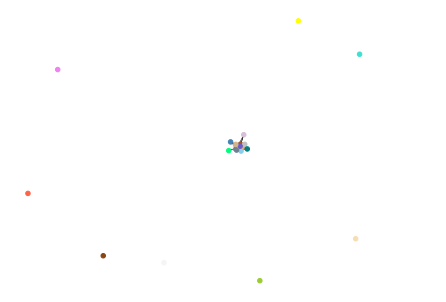

In [21]:
nx.draw(ind, pos=nx.spring_layout(ind), width = 0.5, 
        node_size=20, node_color = cols)

Again, we notice that there are some isolated communities surrounding a set of connected communities. 

### Number of nodes in the communities

Next, we will look at the number of nodes of each community, to see if they are equally distributed or not.

In [22]:
part_values = np.array(list(partition.values()))
list_nodes = np.array(H.nodes)


partition_nodes = []
num_nodes_part = []
for i in range(num_part):
    partition_nodes.append(frozenset(list_nodes[part_values==i]))
    num_nodes_part.append(len(list_nodes[part_values==i]))

Number of nodes in the communities:  [  1   2   2   2   3   3   3   3   4  13  19  24  28  31  37  38  51  72
  86  98 175 228 233 501 583]


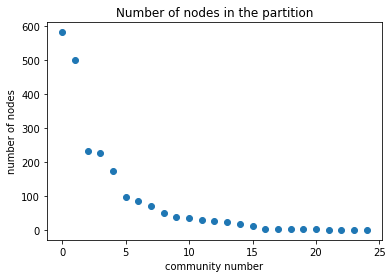

In [26]:
print('Number of nodes in the communities: ', np.array(sorted(num_nodes_part)))
idx = list(np.argsort(-np.array(num_nodes_part)))

plt.plot(np.arange(num_part), np.array(num_nodes_part)[idx], 'o')
plt.title('Number of nodes in the partition')
plt.xlabel('community number')
plt.ylabel('number of nodes')
plt.show()

Observe that there are 10 communities with less than 4 nodes. These communities are therefore isolated. There are some medium communities with 29-250 nodes and then two larger communities with 507 and 607 nodes each.

### Performance and coverage

Apart from the modularity, we are going to assess this partition using two measures:

+ **Performance**: The performance of a partition is the ratio of the number of intra-community edges plus inter-community non-edges with the total number of potential edges.

+ **Coverage**: The coverage of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.

In [10]:
print('Parition performance: ', performance(H, partition_nodes))

print('Partition coverage: ', coverage(H,partition_nodes))

Parition performance:  0.8720582370956422
Partition coverage:  0.6319962686567164


## 2. Clauset-Newman-Moore algorithm

Finally, we are going to use another algorithm to calculate the best partition according to the modularity. This algorithm is implemented within the networkX module.  It uses Clauset-Newman-Moore greedy modularity maximization. Greedy modularity maximization begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists.

In [11]:
nodes_part = greedy_modularity_communities(H)

num_part = len(nodes_part)

print('Number of communities: ', num_part)

Number of communities:  32


With this algorithm, the number of communities is even larger.

### Partition visualization

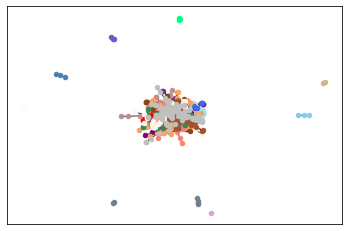

In [12]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(H)
count = 0
cols = list(mcolors.CSS4_COLORS.values())[-num_part:]
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(H, pos, list_nodes, node_size = 20,
                                node_color = cols[count])
    count +=1

nx.draw_networkx_edges(H, pos, alpha=0.8)
plt.show()

Again, we observe that there are some isolated communities. The other communities are connected to each other.

We can calculate the modularity for this partition.

In [13]:
partition = defaultdict(int)

for i in range(num_part):
    for node in nodes_part[i]:
        partition[node] = i

partition = dict(partition)


print('The modularity of our graph is: ', community.modularity(partition, H))

The modularity of our graph is:  0.4719860764004913


The modularity is slightely higher than the one obtained with the previous algorithm.

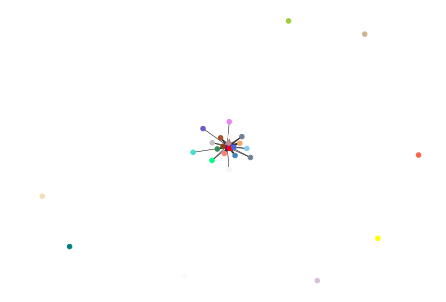

In [14]:
ind = community.induced_graph(partition, H)
nx.draw(ind, pos=nx.spring_layout(ind), width = 0.5, 
        node_size=20, node_color = cols)

Again, we notice that there are some isolated communities surrounding a set of connected communities. It seems that in this case the number of isolated communities is higher than with the other algorithm.

### Number of nodes in the communities

Next, we will look at the number of nodes of each community, to see if they are equally distributed or not.

In [15]:
part_values = np.array(list(partition.values()))
list_nodes = np.array(H.nodes)


partition_nodes = []
num_nodes_part = []
for i in range(num_part):
    partition_nodes.append(frozenset(list_nodes[part_values==i]))
    num_nodes_part.append(len(list_nodes[part_values==i]))

Number of nodes in the communities:  [  1   2   2   2   2   2   3   3   3   3   3   3   4   4   4   4   5   6
   9   9  11  13  20  21  43  51  72 108 278 442 510 597]


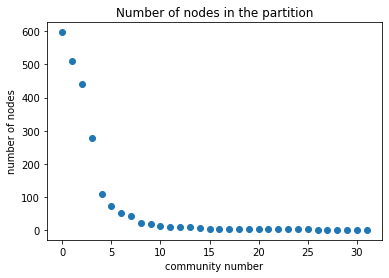

In [16]:
print('Number of nodes in the communities: ', np.array(sorted(num_nodes_part)))
plt.plot(range(num_part), num_nodes_part, 'o')
plt.title('Number of nodes in the partition')
plt.xlabel('community number')
plt.ylabel('number of nodes')
plt.show()

In this case, there are 20 communities with less than 10 nodes. So, there are many more isolated communities.

### Performance and coverage

Finally, let's have a look at the performance and coverage measurements.

In [17]:
print('Parition performance: ', performance(H, nodes_part))

print('Partition coverage: ', coverage(H,nodes_part))

Parition performance:  0.8197114464365469
Partition coverage:  0.7136194029850746


It seems that this partition gives better results in terms of the performance, coverage and modularity. However, it has many more communities and most of them are isolated (with few number of nodes). Therefore, it may be that these small communities lack of physical meaning, even though having better performance in terms of the previous metrics. 

We can also conculde that, regardless of the selected algorithm, the modularity of our partition is quite high, and therefore it seems to be a good partition.